# Developed by Jonathan Ojeda 7/11/2021

### This code was prepared to retrieve APSIM Next Gen outputs and carried out a variance decomposition analysis to identify the main contributors to the variance in selected model outputs

_**Functionality:**_ Calculate the main (ME) and total effect (TE) of a series of factors on the variability of a selected variable (in this example crop biomass).

ME explains the share of the components to crop biomass variability without interactions, 
i.e. if ME=1, the assessed factors explain the entire proportion of crop biomass variability, 
but if M<1, residuals exist which means additional factors are required to explain this variability. 
TE represents the interaction of a given factor with other factors, i.e. high TE values for a given 
factor denote high interactions of that factor with other factors, therefore, TE does not include residuals.

In [1]:
#Required packages
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker

# 1- Read APSIM output from db file
Here we are getting the APSIM outputs from the report (in this example from a harvest report)

In [2]:
path = r'C:\Users\jon_o\Dropbox\APSIM\VarianceDecomposition' #Indicate the path to the db file
db_name = '\\factorial11.db' #Indicate name of the db file
db = sqlite3.connect(path+db_name)
harvest = pd.read_sql("Select * from Report",db)
harvest.rename(columns={'Maize.AboveGround.Wt':'biomass'}, inplace=True) #adjust accordingly with the output variable
harvest.head()

,CheckpointID,SimulationID,Experiment,SowDate,Fertiliser,Cultivar,Site,Zone,Clock.Today,biomass,rain,drain
0,1,4,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1984-05-14 12:00:00,1719.879729,443.400000,34.700530
1,1,4,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1985-04-14 12:00:00,544.958436,272.700002,39.686612
2,1,4,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1986-04-27 12:00:00,1030.119261,511.500000,57.696995
3,1,4,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1987-06-01 12:00:00,687.424128,591.999999,128.205171
4,1,4,Experiment,1-oct,150,Pioneer_34K77,Dry,Field,1988-04-25 12:00:00,736.607115,223.900000,0.000015


# 2- Create categorical clusters for continuous variables
For non-categorical factors is required to create clusters to carried-out the analysis. In this example, we assess the effect of cumulative rainfall during the growing season on the variance of two model outputs. The same logic can be implemented for any non-categorical factor such as mean temperature, radiation, irrigation applied, etc. For this clustering, we used a percentile approach base on percentile 33th and 66th as thresholds for the categories.

In [3]:
RainCluster = []
thres1=np.percentile(harvest["rain"], 33)
thres2=np.percentile(harvest["rain"], 66)
for i in harvest["rain"]:
    if i < thres1:
        RainCluster.append('Low')
    elif i > thres1 and i < thres2:
        RainCluster.append('Med')
    else:
        RainCluster.append('High')     
harvest["RainCluster"] = RainCluster

# 3- Get final dataset before the analysis
* We need to create a dataframe grouping (by mean across years for long-term simulations) based on the selected variables of analysis if years are not part of the analysis.
* It is really important to set `as_index=False` to get the right dataframe format for the analysis.

In [4]:
variables = ['biomass', 'drain']
factors = ['SowDate', 'Fertiliser', 'Cultivar','RainCluster', 'Site']
data = harvest.groupby(factors, as_index=False)[variables].mean().round(decimals=1)
data.head()

,SowDate,Fertiliser,Cultivar,RainCluster,Site,biomass,drain
0,1-dec,100,Dekalb_XL82,High,Dry,883.2,126.6
1,1-dec,100,Dekalb_XL82,High,Mid,1664.4,38.4
2,1-dec,100,Dekalb_XL82,High,Wet,1755.7,49.4
3,1-dec,100,Dekalb_XL82,Low,Dry,663.7,7.7
4,1-dec,100,Dekalb_XL82,Low,Mid,1106.6,0.0


# 4- Quantify the variance crontribution from selected factors for one or more model outputs
For this example `Cultivar`,`sowDate`,`Fertiliser` and `rain` were considered.

The output of this cell is a barplot or barplots (when more than a model output is included) showing the ME and the TE.

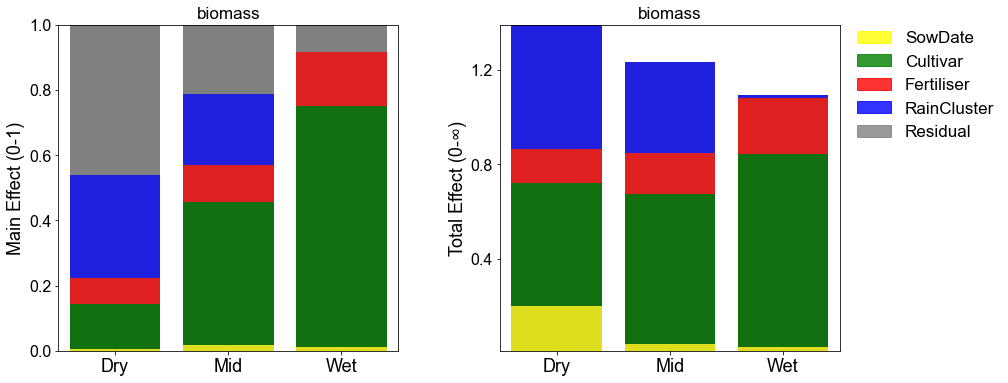

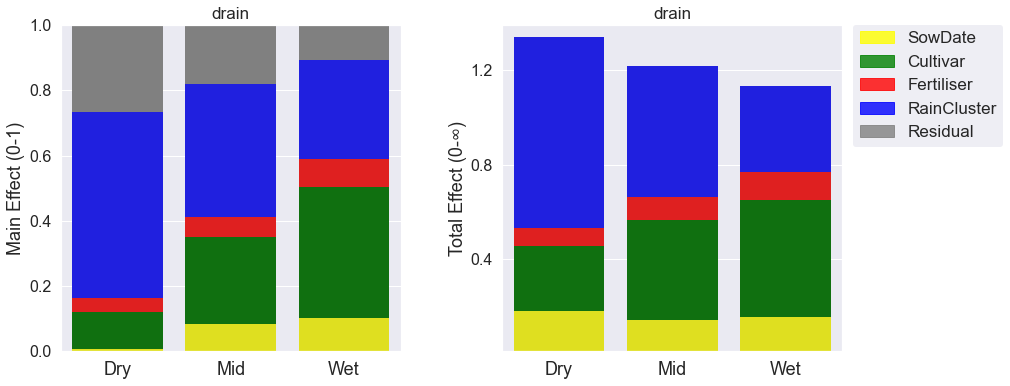

In [5]:
#Indicate in which variables we will asses the variance contribution
variables = ['biomass', 'drain']
#Here you need to add all categories for the classification variable in x axis of the graph (in this case environment)
factors=['SowDate', 'Cultivar', 'Fertiliser', 'RainCluster']
#Indicate x-axis levels
x_categories=['Dry', 'Mid', 'Wet']

f1,f2,f3,f4=[],[],[],[]
for var in variables:
    for category in x_categories:
        x_factor = 'Site' #Change 'x_factor' accordingly with the factor will be used for x-axis in the barplots
        df=data[data[x_factor]==category] 
        df=df.reset_index()
        df=df.drop(columns=x_factor)
        df=df.drop(columns='index')
        totalME=[]
        totalTE=[]
        for factor in factors:
            remaining_factors=['SowDate', 'Cultivar', 'Fertiliser', 'RainCluster'] #add additional factors if required
            remaining_factors.remove(factor)
            TS1_df=list(df.groupby(remaining_factors)[var].mean())
            TS1=1-(np.var(TS1_df)/np.var(list(df[var])))
            TOF_df=list(df.groupby(factor)[var].mean())
            TOP=(np.var(TOF_df)/np.var(list(df[var])))
            f1.append(category)
            f2.append(factor)
            f3.append(TS1)
            f4.append(TOP)
            totalME.append(TOP)
            totalTE.append(TS1)
        # print(sum(totalME)) #uncomment if you want to display the exact ME values plotted
        # print(sum(totalTE)) #uncomment if you want to display the exact TE values plotted

    Summary={'x_factor':f1,
             'factors': f2,
             'Total Effect':f3,
             'Main Effect':f4}
    TS_Summary=pd.DataFrame.from_dict(Summary)
    #TS_Summary.to_csv('TS_Summary.csv') #uncomment if you want to save the raw data used for the plots
    
    #Add more summaries accordingly with the number of factors of analysis
    TS_Summary1b=TS_Summary[TS_Summary['factors']==factors[0]]
    TS_Summary1b=TS_Summary1b.reset_index(drop=True)

    TS_Summary2b=TS_Summary[TS_Summary['factors']==factors[1]]
    TS_Summary2b=TS_Summary2b.reset_index(drop=True)
    TS_Summary2b["Main Effect"]=TS_Summary2b["Main Effect"]+TS_Summary1b["Main Effect"]

    TS_Summary3b=TS_Summary[TS_Summary['factors']==factors[2]]
    TS_Summary3b=TS_Summary3b.reset_index(drop=True)
    TS_Summary3b["Main Effect"]=TS_Summary3b["Main Effect"]+TS_Summary2b["Main Effect"]

    TS_Summary4=TS_Summary[TS_Summary['factors']==factors[3]]
    TS_Summary4b=TS_Summary4.reset_index(drop=True)
    TS_Summary4b["Main Effect"]=TS_Summary4b["Main Effect"]+TS_Summary3b["Main Effect"]

    TS_SummaryDic={'x_factor':f1,
                   'factors': f2,
                   'Total Effect':np.ones(len(f1)),
                   'Main Effect':np.ones(len(f1))}
    TS_Summary5b=pd.DataFrame.from_dict(TS_SummaryDic)

    #Plot configuration
    fig = plt.figure(figsize=(14,6))

    ax = plt.subplot(1,2,1) # Adapt size of the figure accordingly with the number of output variables
    sns.barplot(x = 'x_factor', y = 'Main Effect', data=TS_Summary5b, color = "grey", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Main Effect', data=TS_Summary4b, color = "blue", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Main Effect', data=TS_Summary3b, color = "red", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Main Effect', data=TS_Summary2b, color = "green", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Main Effect', data=TS_Summary1b, color = "yellow", linewidth=0, ci=None)
    plt.ylim([0,1])
    
    #Create legend
    yellow_patch = mpatches.Patch(color='yellow', alpha=.8, label=factors[0])
    green_patch = mpatches.Patch(color='green', alpha=.8, label=factors[1])
    red_patch = mpatches.Patch(color='red', alpha=.8, label=factors[2])
    blue_patch = mpatches.Patch(color='blue', alpha=.8, label=factors[3])
    grey_patch = mpatches.Patch(color='grey', alpha=.8, label='Residual')

    leg=plt.legend(handles=[yellow_patch, green_patch, red_patch, blue_patch, grey_patch], fontsize=17,
                   loc=4,ncol=1, bbox_to_anchor=[2.8, 0.6])   
    
    leg.get_frame().set_linewidth(0.0)
    plt.title(var, fontsize=17)
    plt.xlabel('')
    plt.ylabel('Main Effect (0-1)',fontsize=18)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=18)

    ######################
    ax = plt.subplot(1,2,2) # Adapt size of the figure accordingly with the number of output variables
    sns.set()
    
    #Add more summaries accordingly with the number of factors of analysis
    TS_Summary1=TS_Summary[TS_Summary['factors']==factors[0]]
    TS_Summary1=TS_Summary1.reset_index(drop=True)

    TS_Summary2=TS_Summary[TS_Summary['factors']==factors[1]]
    TS_Summary2=TS_Summary2.reset_index(drop=True)
    TS_Summary2["Total Effect"]=TS_Summary2["Total Effect"]+TS_Summary1["Total Effect"]

    TS_Summary3=TS_Summary[TS_Summary['factors']==factors[2]]
    TS_Summary3=TS_Summary3.reset_index(drop=True)
    TS_Summary3["Total Effect"]=TS_Summary3["Total Effect"]+TS_Summary2["Total Effect"]

    TS_Summary4=TS_Summary[TS_Summary['factors']==factors[3]]
    TS_Summary4=TS_Summary4.reset_index(drop=True)
    TS_Summary4["Total Effect"]=TS_Summary4["Total Effect"]+TS_Summary3["Total Effect"]
    
    #Plot configuration
    sns.barplot(x = 'x_factor', y = 'Total Effect', data=TS_Summary4, color = "blue", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Total Effect', data=TS_Summary3, color = "red", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Total Effect', data=TS_Summary2, color = "green", linewidth=0, ci=None)
    sns.barplot(x = 'x_factor', y = 'Total Effect', data=TS_Summary1, color = "yellow", linewidth=0, ci=None)
    ax.set_ylim([0,1.4])
    plt.title(var, fontsize=17)
    plt.xlabel('')
    plt.ylabel('Total Effect (0-\u221E)',fontsize=18)
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=18)
    ax.set_ylim([0.01,1.39])
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.4))
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())

    plt.subplots_adjust(wspace=0.3, hspace=0)
    #Save plot
    #plt.savefig(path+'\\var_decomp-'+ var + '.png', dpi=300, bbox_inches='tight', pad_inches=0) #uncomment to save figures